In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Directory where files are saved
directory = 'evaluation_results/withEmbeddings'

# Load files
survival = np.load(f'{directory}/patient_survival_outcomes.npy')
agent_q = np.load(f'{directory}/dqn_agent_q_values.npy')
phys_q = np.load(f'{directory}/physician_q_values.npy')
rewards = np.load(f'{directory}/step_rewards.npy')
agent_actions = np.load(f'{directory}/dqn_agent_actions.npy')
phys_actions = np.load(f'{directory}/physician_actions.npy')
agent_q_probs = np.load(f'{directory}/dqn_agent_q_probs.npy')

# Verify shapes
print(f"Shapes: survival={survival.shape}, agent_q={agent_q.shape}, phys_q={phys_q.shape}, "
      f"rewards={rewards.shape}, agent_actions={agent_actions.shape}, "
      f"phys_actions={phys_actions.shape}, agent_q_probs={agent_q_probs.shape}")

Shapes: survival=(34480,), agent_q=(34480,), phys_q=(34480,), rewards=(34480,), agent_actions=(34480,), phys_actions=(34480,), agent_q_probs=(34480,)


bloc_num shape: (34480,), unique patients: 1724
Patient-level survival rate: 0.00%


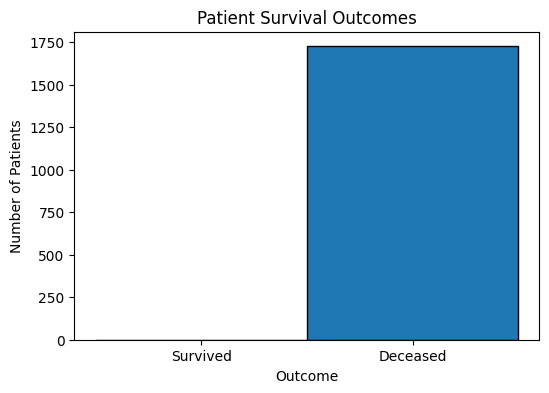

In [3]:
with open('test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)
bloc_num = test_data['Bloc']
print(f"bloc_num shape: {bloc_num.shape}, unique patients: {len(np.unique(bloc_num))}")

# Aggregate survival by patient
unique_patients = np.unique(bloc_num)
patient_survival = np.zeros(len(unique_patients))
for i, patient_id in enumerate(unique_patients):
    patient_mask = bloc_num == patient_id
    patient_survival[i] = survival[patient_mask][0]  # Take first value (constant per patient)

# Compute survival rate
survival_rate = 1 - np.mean(patient_survival)  # 0 = survived, 1 = deceased
print(f"Patient-level survival rate: {survival_rate:.2%}")

# Plot survival distribution
plt.figure(figsize=(6, 4))
plt.hist(patient_survival, bins=[-0.5, 0.5, 1.5], edgecolor='black')
plt.xticks([0, 1], ['Survived', 'Deceased'])
plt.title('Patient Survival Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Number of Patients')
plt.savefig(f'{directory}/survival_histogram.png')
plt.show()

Average empirical return: -0.08 ± 1.29
Average expected Q-value: 7.88 ± 0.00


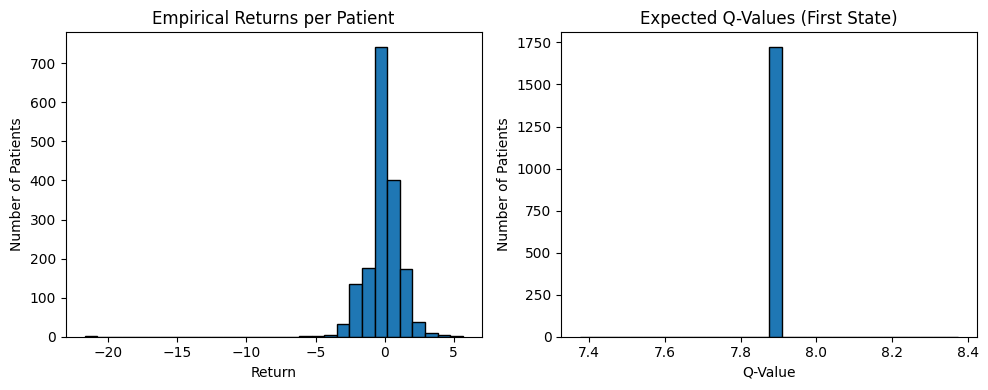

Average physician Q-value: 7.29 ± 0.19


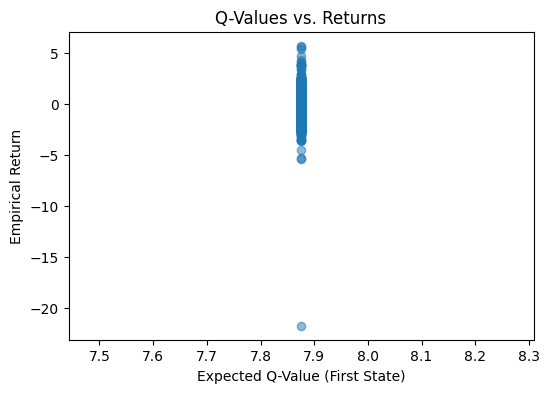

In [4]:
# Compute empirical returns per patient
patient_returns = np.zeros(len(unique_patients))
for i, patient_id in enumerate(unique_patients):
    patient_mask = bloc_num == patient_id
    patient_rewards = rewards[patient_mask]
    # Discounted sum of rewards
    discount_factors = np.power(0.99, np.arange(len(patient_rewards)))
    patient_returns[i] = np.sum(patient_rewards * discount_factors)

# Compute expected Q-values at first state
patient_q_values = np.zeros(len(unique_patients))
for i, patient_id in enumerate(unique_patients):
    patient_mask = bloc_num == patient_id
    patient_q_values[i] = agent_q[patient_mask][0]  # Q-value at first transition

# Statistics
print(f"Average empirical return: {np.mean(patient_returns):.2f} ± {np.std(patient_returns):.2f}")
print(f"Average expected Q-value: {np.mean(patient_q_values):.2f} ± {np.std(patient_q_values):.2f}")

# Plot return distributions
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(patient_returns, bins=30, edgecolor='black')
plt.title('Empirical Returns per Patient')
plt.xlabel('Return')
plt.ylabel('Number of Patients')

plt.subplot(1, 2, 2)
plt.hist(patient_q_values, bins=30, edgecolor='black')
plt.title('Expected Q-Values (First State)')
plt.xlabel('Q-Value')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.savefig(f'{directory}/returns_histogram.png')
plt.show()

# Compare agent vs. physician Q-values
print(f"Average physician Q-value: {np.mean(phys_q):.2f} ± {np.std(phys_q):.2f}")
plt.figure(figsize=(6, 4))
plt.scatter(patient_q_values, patient_returns, alpha=0.5)
plt.xlabel('Expected Q-Value (First State)')
plt.ylabel('Empirical Return')
plt.title('Q-Values vs. Returns')
plt.savefig(f'{directory}/q_vs_returns.png')
plt.show()

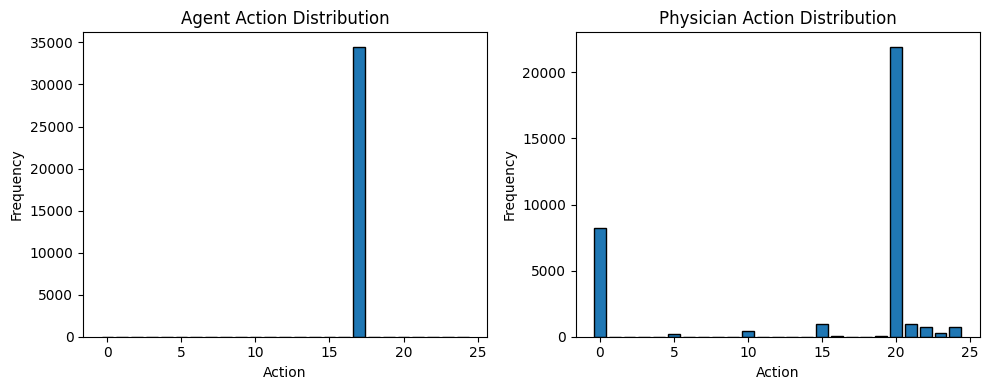

Transition-level action agreement: 0.03%
Patient-level action agreement: 0.03% ± 0.38%


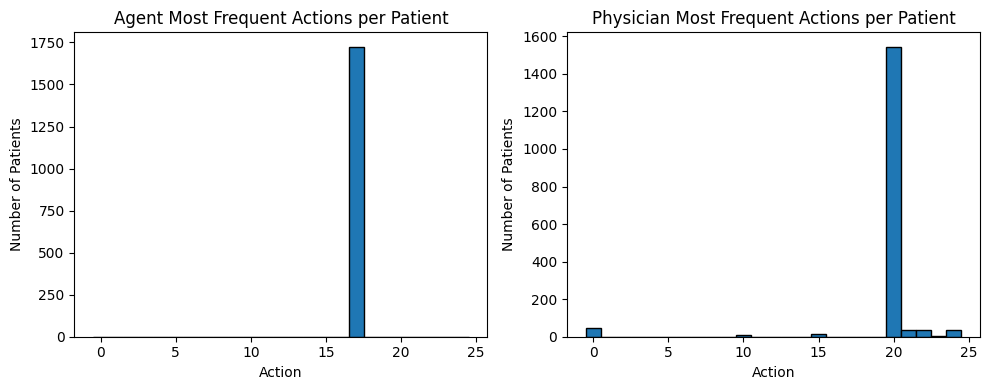

In [5]:
# Action distribution across all transitions
agent_action_counts = np.bincount(agent_actions.astype(int), minlength=25)
phys_action_counts = np.bincount(phys_actions.astype(int), minlength=25)

# Plot action distributions
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(25), agent_action_counts, edgecolor='black')
plt.title('Agent Action Distribution')
plt.xlabel('Action')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.bar(range(25), phys_action_counts, edgecolor='black')
plt.title('Physician Action Distribution')
plt.xlabel('Action')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(f'{directory}/action_distribution.png')
plt.show()

# Action agreement per transition
agreement = np.mean(agent_actions == phys_actions)
print(f"Transition-level action agreement: {agreement:.2%}")

# Patient-level action agreement (average agreement per patient)
patient_agreements = np.zeros(len(unique_patients))
for i, patient_id in enumerate(unique_patients):
    patient_mask = bloc_num == patient_id
    patient_agreements[i] = np.mean(agent_actions[patient_mask] == phys_actions[patient_mask])
print(f"Patient-level action agreement: {np.mean(patient_agreements):.2%} ± {np.std(patient_agreements):.2%}")

# Action distribution per patient (most frequent action)
patient_agent_actions = np.zeros(len(unique_patients), dtype=int)
patient_phys_actions = np.zeros(len(unique_patients), dtype=int)
for i, patient_id in enumerate(unique_patients):
    patient_mask = bloc_num == patient_id
    patient_agent_actions[i] = np.bincount(agent_actions[patient_mask].astype(int), minlength=25).argmax()
    patient_phys_actions[i] = np.bincount(phys_actions[patient_mask].astype(int), minlength=25).argmax()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(patient_agent_actions, bins=np.arange(26)-0.5, edgecolor='black')
plt.title('Agent Most Frequent Actions per Patient')
plt.xlabel('Action')
plt.ylabel('Number of Patients')

plt.subplot(1, 2, 2)
plt.hist(patient_phys_actions, bins=np.arange(26)-0.5, edgecolor='black')
plt.title('Physician Most Frequent Actions per Patient')
plt.xlabel('Action')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.savefig(f'{directory}/patient_action_distribution.png')
plt.show()

Survived returns: nan ± nan
Deceased returns: -0.08 ± 1.29


/opt/homebrew/lib/python3.13/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.13/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/lib/python3.13/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/lib/python3.13/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/homebrew/lib/python3.13/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/lf/wmkwxwwx63g16wbm61mzyxrm0000gn/T/ipykernel_41949/488349749.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot(

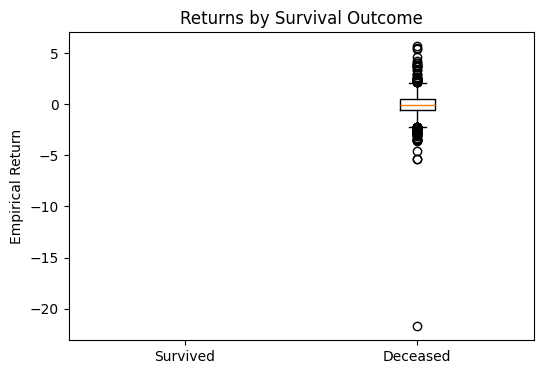

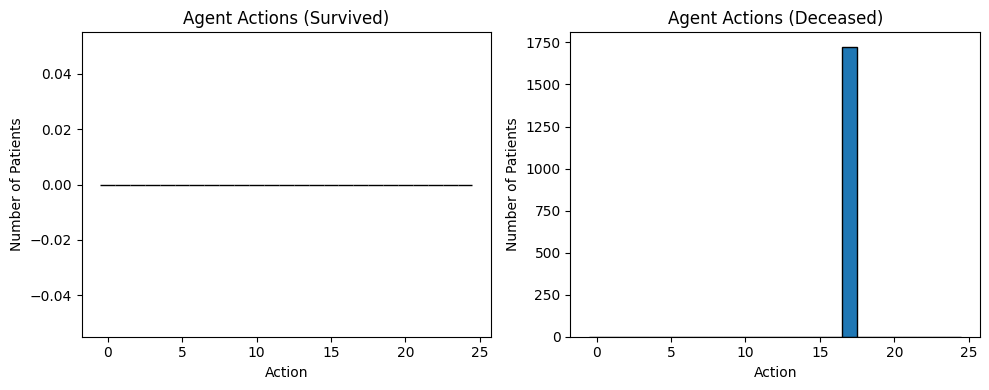

In [6]:
# Split returns by survival outcome
survived_returns = patient_returns[patient_survival == 0]
deceased_returns = patient_returns[patient_survival == 1]
print(f"Survived returns: {np.mean(survived_returns):.2f} ± {np.std(survived_returns):.2f}")
print(f"Deceased returns: {np.mean(deceased_returns):.2f} ± {np.std(deceased_returns):.2f}")

# Plot
plt.figure(figsize=(6, 4))
plt.boxplot([survived_returns, deceased_returns], labels=['Survived', 'Deceased'])
plt.title('Returns by Survival Outcome')
plt.ylabel('Empirical Return')
plt.savefig(f'{directory}/returns_by_survival.png')
plt.show()

# Action distribution by survival
survived_mask = patient_survival == 0
survived_agent_actions = patient_agent_actions[survived_mask]
deceased_agent_actions = patient_agent_actions[~survived_mask]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(survived_agent_actions, bins=np.arange(26)-0.5, edgecolor='black')
plt.title('Agent Actions (Survived)')
plt.xlabel('Action')
plt.ylabel('Number of Patients')

plt.subplot(1, 2, 2)
plt.hist(deceased_agent_actions, bins=np.arange(26)-0.5, edgecolor='black')
plt.title('Agent Actions (Deceased)')
plt.xlabel('Action')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.savefig(f'{directory}/actions_by_survival.png')
plt.show()